# Autoencoder: learning a latent representation of the gauge symmetry

In [1]:
import sys
sys.path.append('src/')
import tools as t
import numpy as np

In [40]:
# linear size of the system
L=5
Lx = L
Ly = L

# Number of sites
N = Lx*Ly

'''
  get the connectivity matrix and the index
  connectivity : dictionnary (x,y) -> J_{xy}
  getindex : array idx -> (x,y)
'''
connectivity,getindex=t.compute_connectivity(Lx,Ly)

## ncmax=int(0.5*len(connectivity))

# number of samples
NS=100000

print("L=",L)
print("NS=",NS)


L= 5
NS= 50000


## Creating the dataset

First, we construct a set of Ngauge orbits

In [41]:
xdim = 2 * Lx 
ydim = 2 * Ly
    
# Creating a set of Ngauge random orbits
Ngauge = 1000 # number of gauge orbits

Chess_g = np.zeros((Ngauge,xdim,ydim))
# Ngauge/2 random samples
for ng in range(Ngauge//2):
    Chess_g[ng,:,:] = t.createSample_2D(connectivity, Lx,Ly)

# Ngauge/2 samples that are created to be near the first ones
for ng in np.arange(Ngauge//2,Ngauge):
    ng_rdm = np.random.choice(range(Ngauge//2))
    transformation_type=np.random.choice(range(2))
    '''
    transformation_type : choose which type of modification
      0=R_q : flip q random Js
      1=L : breaking a line
    '''   
    if transformation_type==0:
        nchanges=np.random.choice(range(1,4))+0.1
        q=nchanges/len(connectivity)
        Trasf = t.getRandom_2D(Chess_g[ng_rdm,:,:], connectivity, q, Lx,Ly) 
    if transformation_type==1:
        Trasf = t.getLine_2D(Chess_g[ng_rdm,:,:],connectivity, Lx,Ly)
        
    Chess_g[ng] = t.getOrbit_2D(Trasf,connectivity,Lx,Ly)
    

#### Then we build pair of samples-gaugefixed(samples) for the autoenoder

In [42]:
X_train = np.zeros((NS,xdim,ydim,1))
y_train = np.zeros((NS,xdim,ydim,1))
label = np.zeros(NS)
for ns in range(NS):
    gauge = np.random.randint(Ngauge)
    # X_train : we put a gauge transform of an orbit choosen randomly
    X_train[ns, :, :, 0] = t.getOrbit_2D(Chess_g[gauge,:,:],connectivity, Lx, Ly)
    # y_train : the gauge-fixed version of X_train
    y_train[ns, :, :, 0] = t.gauge_fixing_Comb(Chess_g[gauge,:,:],connectivity,Lx,Ly)
    
    # we save to which gauge the sample belongs 
    label[ns] = gauge

#### Building the true test set (with independant samples)

In [43]:
NS_Test = 5000
X_test = np.zeros((NS_Test, xdim, ydim, 1))
y_test = np.zeros((NS_Test, xdim, ydim, 1))
for i in range(NS_Test):
    Smpl = t.createSample_2D(connectivity, Lx,Ly)
    X_test[i,:,:,0] = Smpl
    y_test[i,:,:,0] = t.gauge_fixing_Comb(X_test[i,:,:,0],connectivity,Lx,Ly)


## Constructing the AutoEncoder

In [44]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Reshape, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam

Strain = X_train.shape[0]
Stest = X_test.shape[0]


input_data = Input(shape=(xdim,ydim,1))

# ENCODER DNN
NFilterLines = 16 # No. of filters for the horizontal & vertical slab-CNNs
NFiltersPlaq = 32 # No. of filters for the plaquettes CNNs

# one layer getting vertical filter
vert_conv2D = Conv2D(NFilterLines,(1,ydim),activation='relu', padding='valid',strides=(1,1))(input_data)
vert_conv2D = Flatten()(vert_conv2D)
# one layer getting horizontal filter
horiz_conv2D = Conv2D(NFilterLines,(xdim,1),activation='relu', padding='valid',strides=(1,1))(input_data)
horiz_conv2D = Flatten()(horiz_conv2D)
# one layer for the plaquette
plaq_conv2D = Conv2D(NFiltersPlaq,(3,3),activation='relu', padding='same',strides=(2,2))(input_data)
plaq_conv2D = Flatten()(plaq_conv2D)

# We concatenate the outputs from the three CNNs
x = concatenate([plaq_conv2D,vert_conv2D,horiz_conv2D])
Encoded = Dense(5*5*2,activation='relu')(x)

#DECODER DNN
NFilters_Dec = 64
x = Reshape((5,5,2),input_shape=(6*6*64,))(Encoded)
x = Conv2D(NFilters_Dec,(3,3),activation='relu', padding='same',strides=(1,1))(x)

x = UpSampling2D(size=(2,2))(x)
dec_sqr = Conv2D(NFilters_Dec//2,(3,3),activation='relu', padding='same',strides=(1,1))(x)
dec_horiz = Conv2D(NFilters_Dec//2,(1,ydim),activation='relu', padding='same',strides=(1,1))(x)
dec_vert = Conv2D(NFilters_Dec//2,(xdim,1),activation='relu', padding='same',strides=(1,1))(x)

x = concatenate([dec_sqr,dec_horiz,dec_vert])
Decoded = Conv2D(1,(5,5),activation='linear', padding='same',strides=(1,1))(x)

# we define the encoder separately for a later study (not used for the fit)
ENC = Model(input_data,Encoded)


# building the AutoEncoder
DCAE = Model(input_data,Decoded)
DCAE.summary()
DCAE.compile(optimizer="Adam",loss="mean_squared_error", metrics=["accuracy"])

b_size = 32
epochs = 4

DCAE.fit(X_train,y_train, epochs=epochs, batch_size=b_size, validation_data=(X_test,y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 10, 10, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 5, 5, 32)     320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 10, 1, 16)    176         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 1, 10, 16)    176         input_9[0][0]                    
__________________________________________________________________________________________________
flatten_12

## Testing the AutoEncoder
We build three samples :
* X1 : a random one
* X1_G : is a gauge transformation of XA
* X1_RDM : is a random one

Then we test the prediction of the network, it should be the same for X1 and X1_G.
We also test if they belong to the same fixed-gauge.

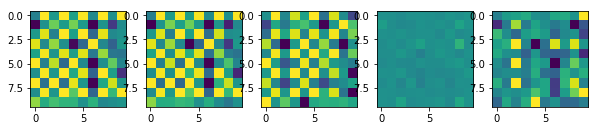

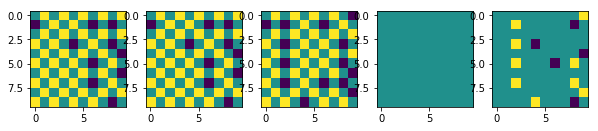

In [45]:
import matplotlib.pyplot as plt

X1 = t.createSample_2D(connectivity, Lx,Ly)
X1_G = t.getOrbit_2D(X1,connectivity, Lx, Ly)
X1_RDM = t.createSample_2D(connectivity, Lx,Ly)

X1_p     = DCAE.predict(X1.reshape((1,xdim,ydim,1)))
X1_G_p   = DCAE.predict(X1_G.reshape((1,xdim,ydim,1)))
X1_RDM_p = DCAE.predict(X1_RDM.reshape((1,xdim,ydim,1)))

f,ax = plt.subplots(1,5,figsize=(10,10))
ax[0].imshow(X1_p[0,:,:,0],vmin=-1,vmax=1)
ax[1].imshow(X1_G_p[0,:,:,0],vmin=-1,vmax=1)
ax[2].imshow(X1_RDM_p[0,:,:,0],vmin=-1,vmax=1)
ax[3].imshow(X1_p[0,:,:,0]-X1_G_p[0,:,:,0],vmin=-1,vmax=1)
ax[4].imshow(X1_p[0,:,:,0]-X1_RDM_p[0,:,:,0],vmin=-1,vmax=1)

G1     = t.gauge_fixing_Comb(np.sign(X1_p[0,:,:,0]),connectivity,Lx,Ly)
G1_G   = t.gauge_fixing_Comb(np.sign(X1_G_p[0,:,:,0]),connectivity,Lx,Ly)
G1_RDM = t.gauge_fixing_Comb(np.sign(X1_RDM_p[0,:,:,0]),connectivity,Lx,Ly)

f,ax = plt.subplots(1,5,figsize=(10,10))
ax[0].imshow(G1,vmin=-1,vmax=1)
ax[1].imshow(G1_G,vmin=-1,vmax=1)
ax[2].imshow(G1_RDM,vmin=-1,vmax=1)
ax[3].imshow(G1-G1_G,vmin=-1,vmax=1)
ax[4].imshow(G1-G1_RDM,vmin=-1,vmax=1)


## Comparison of the latent representation of the Encoder

Starting from a random sample (named $J$), we make a scatter between the latent representation $J$ and of other cases
* with an orbit of $J$
* with a sample that differ only by a $q$ flipped couplings
* with a sample where a line is broken
* with a random sample 

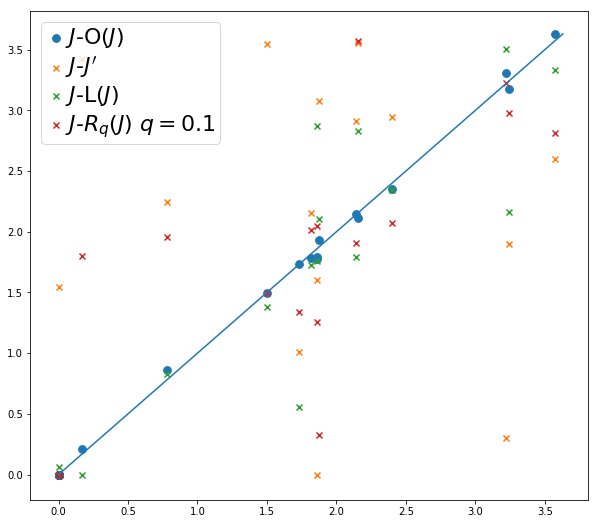

In [46]:
X1_enc = ENC.predict(X1.reshape((1,xdim,ydim,1)))
X1_G_enc = ENC.predict(X1_G.reshape((1,xdim,ydim,1)))
X1_RDM_enc = ENC.predict(X1_RDM.reshape((1,xdim,ydim,1)))
X1_Line = ENC.predict(t.getLine_2D(X1, connectivity, Lx,Ly).reshape((1,xdim,ydim,1)))
X1_Q = ENC.predict(t.getRandom_2D(X1, connectivity, 0.1, Lx,Ly).reshape((1,xdim,ydim,1)))

xm = max(np.concatenate((X1_enc[0,:],X1_G_enc[0,:],X1_Line[0,:],X1_Q[0,:],X1_RDM_enc[0,:]),axis=0))
myx = np.arange(0,xm,0.01)
plt.figure(figsize=(10,9))
plt.scatter(X1_enc[0,:],X1_G_enc[0,:],marker='o',label="$J$-O($J$)",s=60)
plt.scatter(X1_enc[0,:],X1_RDM_enc[0,:],marker='x',label="$J$-$J'$")
plt.scatter(X1_enc[0,:],X1_Line[0,:],marker='x',label="$J$-L($J$)")
plt.scatter(X1_enc[0,:],X1_Q[0,:],marker='x',label="$J$-$R_q(J)$ $q=0.1$")
plt.plot(myx,myx,'-')# ,label="y=x")
plt.legend(prop={'size': 22},handletextpad=0,borderpad=0.2,labelspacing=0.2,handlelength=0.9,loc=2)

In [29]:
# Saving the weights of the AutoEncoder
DCAE.save_weights("DCAE_Ex1.d")

## Classifying using the latent representation

#### Creating a new dataset for classification

In [47]:
NS=2000
NS_GG=NS_GL=NS

DataSet = np.zeros((NS_GG  + NS_GL, xdim, ydim, 2))
Labels = np.zeros((NS_GG + NS_GL))
Labels2 = np.zeros((NS_GG + NS_GL))

DS_G = np.zeros((1000, xdim, ydim, 2))
DS_Q = np.zeros((1000, xdim, ydim, 2))
DS_LINE = np.zeros((1000, xdim, ydim, 2))

for ns in range(NS_GG):
    Chess = t.createSample_2D(connectivity, Lx,Ly)
    DataSet[ns, :, :, 0] = Chess
    DataSet[ns, :, :, 1] = t.getOrbit_2D(Chess,connectivity, Lx,Ly)

for ns in range(NS_GG, NS_GG + NS_GL):
    Chess = t.createSample_2D(connectivity, Lx,Ly)
    DataSet[ns, :, :, 0] = Chess 

    tipo=np.random.choice(range(2))    
    if tipo==0:
        q0= 0.1
        q=np.random.random()*0.25+q0
        Trasf = t.getRandom_2D(Chess, connectivity, q, Lx,Ly)    
    if tipo==1:
        Trasf = t.getLine_2D(Chess,connectivity, Lx,Ly)
        
    Trasf = t.getOrbit_2D(Trasf,connectivity, Lx,Ly)
    DataSet[ns, :, :, 1] = Trasf
    
Labels[NS_GG: NS_GG + NS_GL] = 1


for ns in range(1000):
    Chess = t.createSample_2D(connectivity, Lx,Ly)
    DS_G[ns, :, :, 0] = Chess
    DS_G[ns, :, :, 1] = t.getOrbit_2D(Chess,connectivity, Lx,Ly)
    DS_Q[ns, :, :, 0] = Chess
    DS_LINE[ns, :, :, 0] = Chess
    
    q0=0.1 # 1./Lx/Ly
    q=np.random.random()*0.25+q0
    DS_Q[ns, :, :, 1] = t.getOrbit_2D(t.getRandom_2D(Chess, connectivity, q, Lx,Ly),connectivity,Lx,Ly)
    DS_LINE[ns, :, :, 1] = t.getOrbit_2D(t.getLine_2D(Chess, connectivity, Lx,Ly),connectivity,Lx,Ly)
    
permutation = np.random.permutation(Labels.shape[0])
DataSet = DataSet[permutation,:,:,:]
Labels = Labels[permutation]
X_train_C,y_train_C,X_test_C,y_test_C = t.SplitSet(DataSet,Labels,0.8)


In [48]:
# Make a network to classify the hidden representation
from keras.layers import concatenate, Conv1D, MaxPooling1D
from keras.utils import to_categorical


input_shape = (xdim,ydim,1)
# create two different input (going through the same NN)
left_input =  Input(input_shape)
right_input =  Input(input_shape)
encoded_left = ENC(left_input)             
encoded_right = ENC(right_input)
both = concatenate([encoded_left,encoded_right])

# Do not train the encoder
ENC.trainable = False

x = Reshape((5*5*2,2),input_shape=(5*5*4*2,))(both)
x = Conv1D(16,(32),activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=(2))(x)
x = Conv1D(32,(16),activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=(2))(x)

x = Flatten()(x)
x = Dense(32,activation='relu')(x)
Out = Dense(2,activation='softmax')(x)

Classif = Model(input=[left_input,right_input],output=Out)
Classif.summary()

Classif.compile(optimizer='Adam',loss="categorical_crossentropy", metrics=["accuracy"])

b_size = 32
epochs = 30

Strain_C = X_train_C.shape[0]
Stest_C = X_test_C.shape[0]
Classif.fit([X_train_C[:,:,:,0].reshape(Strain_C,xdim,ydim,1),X_train_C[:,:,:,1].reshape(Strain_C,xdim,ydim,1)],to_categorical(y_train_C),epochs=epochs,batch_size=b_size
            ,validation_data=([X_test_C[:,:,:,0].reshape(Stest_C,xdim,ydim,1),X_test_C[:,:,:,1].reshape(Stest_C,xdim,ydim,1)],to_categorical(y_test_C)))

/home/aurele/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 10, 10, 1)    0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 10, 10, 1)    0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 50)           56722       input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 100)          0           model_8[1][0]                    
          

#### We can check the learning on different cases

In [49]:
# put only random : 

print("Prediction on J-O(J) samples")
print(np.mean(Classif.predict([DS_G[:,:,:,0:1],DS_G[:,:,:,1:2]]),0))
print("Prediction on J-R_q(J) samples")
print(np.mean(Classif.predict([DS_Q[:,:,:,0:1],DS_Q[:,:,:,1:2]]),0))
print("Prediction on J-L(J) samples")
print(np.mean(Classif.predict([DS_LINE[:,:,:,0:1],DS_LINE[:,:,:,1:2]]),0))

Prediction on J-O(J) samples
[0.9118339  0.08816634]
Prediction on J-R_q(J) samples
[0.00458167 0.9954187 ]
Prediction on J-L(J) samples
[0.07529365 0.9247074 ]
